In [1]:
from polygon import RESTClient
import pandas as pd
import numpy as np
import datetime as dt
import requests
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

client = RESTClient("2zH7AFDp4wW1Uqov4zGvbpA2aUNHbk__adRrOG")  # POLYGON_API_KEY environment variable is used

In [2]:
def get_stock(ticker, multiplier, timespan, start_date, end_date):
    
    # Construct the URL
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_date}/{end_date}"
    params = {
        "apiKey": API_KEY,
        "adjusted": "false" ,
        "limit":50000
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check response status
    if response.status_code == 200:
        print("success")
    else:
        print(f"Error: {response.status_code}, {response.text}")

    df = pd.DataFrame(response.json()['results'])
    df['t'] = pd.to_datetime(df['t'], unit='ms')  # Convert timestamp to datetime
    df.set_index('t', inplace=True)  # Set timestamp as index
    df.rename(columns={'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume','n':'n_trades'}, inplace=True)

    return df

success


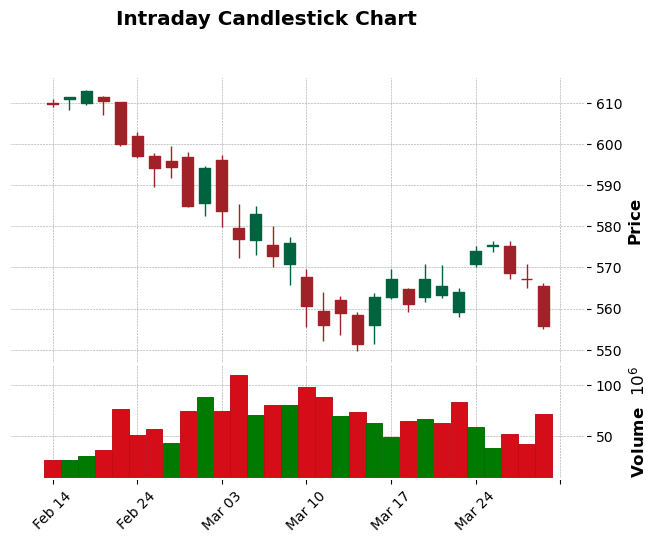

In [3]:
import datetime as dt
import pytz
import time

def convert_to_us_time(df, timezone='US/Eastern'):
    """
    Convert the timestamp to US Eastern Time.
    """
    eastern = pytz.timezone(timezone)
    df.index = df.index.tz_localize(pytz.utc).tz_convert(eastern)
    return df

today_string = dt.datetime.now().date().strftime('%Y-%m-%d')

API_KEY = "2zH7AFDp4wW1Uqov4zGvbpA2aUNHbk__adRrOG"
multiplier = 1
timespan = "day"
start_date = "2024-01-01"
end_date = today_string

stocks = {}
for ticker in ['SPY']:
    stock = convert_to_us_time(get_stock(ticker, multiplier, timespan,start_date,end_date))
    stocks[ticker] = stock

import mplfinance as mpf

# Select the required columns for the candlestick plot
data = stocks['SPY'][['Open', 'High', 'Low', 'Close', 'Volume']].tail(30)

# Plot the candlestick chart
mpf.plot(data, type='candle', volume=True, title= 'Intraday Candlestick Chart', style='charles')

## Fair Volatility Estimate
<br> Third EyE market

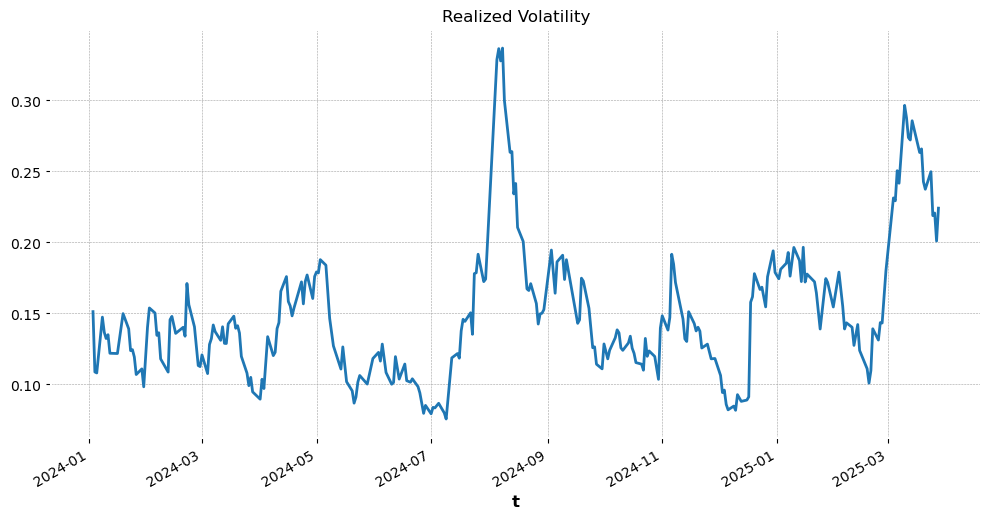

In [4]:
spy = stocks['SPY'].copy()

spy['close_to_high'] = np.log(spy['High'] / spy['Close'].shift(1)) 
spy['close_to_low'] = np.log(spy['Low'] / spy['Close'].shift(1))

adj_factor1 = 1
spy['range high - low'] = abs(spy['close_to_high']) - abs(spy['close_to_low'])
spy['realized vol'] = np.sqrt(252) * abs(spy.apply(lambda x: x['close_to_high'] if x['range high - low'] >= 0 else x['close_to_low'], axis=1))
spy['ewm realized vol'] = spy['realized vol'].ewm(span = 11).mean() * adj_factor1
spy['ewm realized vol'].plot(figsize=(12, 6), title='Realized Volatility')


## Garch VLAB

In [15]:
pd.read_csv('zesenyingfun/fin/data/VIX_History.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'zesenyingfun/fin/data/VIX_History.csv'